# inforet 2024 3

### bm 25 tests and query expansion by synonyms

In [1]:
!pip install rank_bm25 spacy Sense2Vec
!wget https://github.com/explosion/sense2vec/releases/download/v1.0.0/s2v_reddit_2015_md.tar.gz
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from rank_bm25 import BM25Okapi
import spacy
from sense2vec import Sense2Vec
tqdm.pandas()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
  Using cached preshed-3.0.9-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached typer-0.15.2-py3-none-any.whl.metadata (15 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.27.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-3.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urlli

In [2]:
# this turns on the autotimer, so that every cell has a timing information below
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime
# stop using:
# %unload_ext autotime

time: 140 μs (started: 2025-03-25 15:33:11 +01:00)


## getting the best combinations from last time and writing them into files

In [3]:
origdocs = pd.read_csv('our.msmarco.docs.tsv',sep='\t',usecols=[1,2,3])
origdocs['title'].fillna('-', inplace=True)
origdocs['body'].fillna('-', inplace=True)
origdocs

/tmp/ipykernel_330731/3535312669.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  origdocs['title'].fillna('-', inplace=True)
/tmp/ipykernel_330731/3535312669.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

,docid,title,body
0,D2981241,What do you call a group of lions?,Lions Vocabulary of the English Language Word ...
1,D687756,.,"The A Priori Argument ( also, Rationalization;..."
2,D913099,Everything You Need To Learn How To Cook Veget...,Home > How To Cook Vegetables Everything You N...
3,D328017,"What is the difference between latitude, longi...",Longitude Latitude Geographic Coordinate Syste...
4,D1636347,When was the pulley invented?,Answers.com ® Wiki Answers ® Categories Techno...
...,...,...,...
92560,D3379210,Top 39 Doctor insights on: Can An Iud Cause Ha...,Top 39 Doctor insights on: Can An Iud Cause Ha...
92561,D3068739,How to get back your DirecTV cancellation fees,How to get back your Direc TV cancellation fee...
92562,D1590402,Certification FAQs,Fingerprinting 1. Where can I get fingerprinte...
92563,D2175490,Greenhouse gas emissions by Canadian economic ...,"Access PDF (682 KB)In 2015, Canada's total gre..."


time: 13.9 s (started: 2025-03-25 15:35:59 +01:00)


In [4]:
docs = pd.DataFrame(columns = ['docid', 'text'])
docs['docid']=origdocs.docid
docs['text']=origdocs.title+' '+origdocs.body
docs

,docid,text
0,D2981241,What do you call a group of lions? Lions Vocab...
1,D687756,". The A Priori Argument ( also, Rationalizatio..."
2,D913099,Everything You Need To Learn How To Cook Veget...
3,D328017,"What is the difference between latitude, longi..."
4,D1636347,When was the pulley invented? Answers.com ® Wi...
...,...,...
92560,D3379210,Top 39 Doctor insights on: Can An Iud Cause Ha...
92561,D3068739,How to get back your DirecTV cancellation fees...
92562,D1590402,Certification FAQs Fingerprinting 1. Where can...
92563,D2175490,Greenhouse gas emissions by Canadian economic ...


time: 1.33 s (started: 2025-03-25 15:36:13 +01:00)


In [5]:
del origdocs # saving memory

time: 464 μs (started: 2025-03-25 15:36:14 +01:00)


In [6]:
docs.to_csv('our.text.msmarco.docs.tsv',sep='\t', columns=['docid','text'])

time: 19.8 s (started: 2025-03-25 15:36:21 +01:00)


#### and now the pre-tokenization for bm25

In [7]:
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode')
tokenized_corpus = docs.text.progress_apply(vectorizer.build_analyzer())
#docs['docid'].to_frame().join(tokenized_corpus)

  0%|          | 0/92565 [00:00<?, ?it/s]

time: 2min 19s (started: 2025-03-25 15:36:41 +01:00)


In [8]:
type(tokenized_corpus)

pandas.core.series.Series

time: 3.38 ms (started: 2025-03-25 15:39:01 +01:00)


## reading back in just for checking the files - or for restarting here

In [9]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from rank_bm25 import BM25Okapi

tqdm.pandas()

time: 1.33 ms (started: 2025-03-25 15:40:03 +01:00)


In [10]:
# this is a different doc, no longer distinguishing title and body
docs = pd.read_csv('our.text.msmarco.docs.tsv',sep='\t',usecols=[1,2]) 
docs

,docid,text
0,D2981241,What do you call a group of lions? Lions Vocab...
1,D687756,". The A Priori Argument ( also, Rationalizatio..."
2,D913099,Everything You Need To Learn How To Cook Veget...
3,D328017,"What is the difference between latitude, longi..."
4,D1636347,When was the pulley invented? Answers.com ® Wi...
...,...,...
92560,D3379210,Top 39 Doctor insights on: Can An Iud Cause Ha...
92561,D3068739,How to get back your DirecTV cancellation fees...
92562,D1590402,Certification FAQs Fingerprinting 1. Where can...
92563,D2175490,Greenhouse gas emissions by Canadian economic ...


time: 14 s (started: 2025-03-25 15:40:04 +01:00)


In [11]:
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode')
tokenized_corpus = docs.text.progress_apply(vectorizer.build_analyzer())

  0%|          | 0/92565 [00:00<?, ?it/s]

time: 2min 33s (started: 2025-03-25 15:40:18 +01:00)


In [12]:
# use only col 1 if you have memory problems and do BM25 only
queries = pd.read_csv('our.msmarco.queries.tsv',sep='\t',usecols=[1,2]) 
training_queries=queries.iloc[:500]
testing_queries=queries.iloc[500:]
training_queries

,qid,query
0,687888,what is a jpe
1,480210,price for asphalt driveway
2,591004,what causes pressure skin bruising
3,260536,how long drive from flagstaff to grand canyon
4,39422,average number of bowel movements per day for ...
...,...,...
495,133970,definition of dietary fiber
496,79788,can you start up a video record?
497,791583,what is rheumatoid spondylosis
498,732078,what is coleman fuel made out of


time: 64 ms (started: 2025-03-25 15:42:51 +01:00)


In [13]:
gold = pd.read_csv('our.msmarco.gold.tsv',sep='\t',usecols=[1,3,4,5])
gold

,qid,docid,rank,score
0,310290,D579750,1,-5.11498
1,310290,D579754,2,-5.57703
2,310290,D2380815,3,-5.84852
3,310290,D822566,4,-5.95002
4,310290,D2249695,5,-6.08326
...,...,...,...,...
99995,257942,D253854,96,-6.32693
99996,257942,D3056621,97,-6.32837
99997,257942,D1323491,98,-6.32871
99998,257942,D2722485,99,-6.33100


time: 141 ms (started: 2025-03-25 15:42:52 +01:00)


# redoing the vectorization for my two best results

### 🚧 todo:
### use TfidfVectorizer, BM25Okapi, and our own BM25 function
to measure whether there are significant differences.


In [21]:
def pAt10(qid):
    query = queries[queries.qid==qid]['query']
    qv = vectorizer.transform(query)
    xqv = X*qv.T
    pred10i = np.argpartition(xqv.toarray().flat, -10)[-10:]
    intersection = np.intersect1d(docs.loc[pred10i].docid,gold[gold.qid==qid].docid)
    return len(intersection)/10

time: 1.1 ms (started: 2025-03-25 16:14:43 +01:00)


In [22]:
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode')
X = vectorizer.fit_transform(docs.text)
print(len(vectorizer.get_feature_names_out()),'features, for example',vectorizer.get_feature_names_out()[44444:44449])
tfidfresults = training_queries.qid.progress_apply(pAt10)
tfidfresults.mean()

2067446 features, for example ['0highest' '0highs' '0highways' '0hihow' '0hill']


  0%|          | 0/500 [00:00<?, ?it/s]

np.float64(0.9348)

time: 5min 54s (started: 2025-03-25 16:14:44 +01:00)


In [23]:
def pAt10Bm25(qid):
    tquery = queries[queries.qid==qid]['query'].apply(vectorizer.build_analyzer())
    doc_scores = bm25.get_scores(tquery.tolist()[0])
    pred10i = np.argpartition(doc_scores, -10)[-10:]
    intersection = np.intersect1d(docs.loc[pred10i].docid,gold[gold.qid==qid].docid)
    return len(intersection)/10

time: 1.37 ms (started: 2025-03-25 16:20:39 +01:00)


In [24]:
bm25 = BM25Okapi(tokenized_corpus)
bm25results = training_queries.qid.progress_apply(pAt10Bm25)
bm25results.mean()

  0%|          | 0/500 [00:00<?, ?it/s]

np.float64(0.9848)

time: 2min 53s (started: 2025-03-25 16:20:39 +01:00)


In [25]:
from math import log

N = len(tokenized_corpus)
doc_freq = Counter()   # how many docs contain a term
term_freqs = []        # term_freqs[i] = Counter for doc i
doc_len = []

for doc in tqdm(tokenized_corpus, desc="Custom BM25"):
    counts = Counter(doc)
    term_freqs.append(counts)
    doc_len.append(len(doc))
    for token in counts:
        doc_freq[token] += 1

avgdl = np.mean(doc_len)
k1 = 1.2
b  = 0.75

def bm25_score_one_doc(query_tokens, doc_index):
    score = 0.0
    freq_dict = term_freqs[doc_index]
    d_length = doc_len[doc_index]
    for t in query_tokens:
        # Document frequency of term t
        df = doc_freq.get(t, 0)
        # IDF
        idf = log((N - df + 0.5)/(df + 0.5) + 1)
        # freq of term t in this doc
        f = freq_dict.get(t, 0)
        # BM25 formula piece
        numerator = f * (k1 + 1)
        denominator = f + k1 * (1 - b + b * (d_length / avgdl))
        score += idf * (numerator / denominator)
    return score

def custom_bm25_get_scores(query_tokens):
    scores = np.zeros(N)
    for i in range(N):
        scores[i] = bm25_score_one_doc(query_tokens, i)
    return scores

def pAt10_own_bm25(qid):
    tquery = queries[queries.qid == qid]['query'].apply(vectorizer.build_analyzer())
    # There's only one row for that qid, so we take .tolist()[0]
    query_tokens = tquery.tolist()[0]
    scores = custom_bm25_get_scores(query_tokens)
    pred10i = np.argpartition(scores, -10)[-10:]
    intersection = np.intersect1d(
        docs.iloc[pred10i].docid, 
        gold[gold.qid == qid].docid
    )
    return len(intersection) / 10

customBM25results = training_queries.qid.progress_apply(pAt10_own_bm25)
customBM25results.mean()

Custom BM25:   0%|          | 0/92565 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

np.float64(0.986)

time: 6min 37s (started: 2025-03-25 16:23:33 +01:00)


# 🔎 manual error mining
- let's look at where things go wrong

### 🚧 todo:
- what's the lowest p@10 we got
- what's the 10 questions that got the worst score, from worst to slightly better?


In [26]:
lowest_p10_bm25 = bm25results.min()
lowest_p10_bm25

np.float64(0.1)

time: 4.96 ms (started: 2025-03-25 16:30:10 +01:00)


In [27]:
worst10bm25i = bm25results.sort_values().head(10).index
worst10bm25i

Index([172, 398, 37, 308, 285, 167, 443, 456, 184, 455], dtype='int64')

time: 3.83 ms (started: 2025-03-25 16:30:10 +01:00)


In [28]:
worst10_queries = training_queries.loc[worst10bm25i].copy()
worst10_queries['bm25_p@10'] = bm25results.loc[worst10bm25i].values
worst10_queries

,qid,query,bm25_p@10
172,729561,what is channeling,0.1
398,195543,goes how long cost and valid,0.2
37,417380,is mark applier?,0.4
308,651254,what does the name connor mean,0.5
285,127145,define skin doctor,0.6
167,859358,what is uplifting in geography,0.6
443,11059,actresses who died of lung cancer,0.6
456,868366,what kind of food should heart attached person,0.7
184,1078582,wired definition,0.7
455,567103,what are the airports in south virginia,0.7


time: 9.76 ms (started: 2025-03-25 16:30:10 +01:00)


### 🚧 todo:
- write a function showDoc that takes qid, rank, and predicted as parameters
    - if predicted=True, shows the predicted doc of rank rank to the query qid
    - if predicted=False, shows the gold doc
    - prints the first 999 characters of the texts
- for the worst query
    - look at the 10 best gold vs 10 best predicted 
    - hypothetize why the results are so bad for the worst query

In [29]:
def showDoc(qid, rank, predicted=False, topK=10):
    if not predicted:
        gold_doc_row = gold.query("qid == @qid & rank == @rank")
        if gold_doc_row.empty:
            print(f"[Gold] No doc found for qid={qid}, rank={rank}")
            return
        gold_docid = gold_doc_row['docid'].values[0]
        text_matches = docs.loc[docs.docid == gold_docid, 'text']
        if text_matches.empty:
            print(f"[Gold] docid={gold_docid} found in gold, but missing in docs.")
            return
        print(f"Gold doc (qid={qid}, rank={rank}): docid={gold_docid}")
        print(text_matches.values[0][:999])
        
    else:
        query_str = queries.loc[queries.qid == qid, 'query'].values[0]
        query_tokens = vectorizer.build_analyzer()(query_str)
        
        scores = bm25.get_scores(query_tokens)
        
        topK_idx = np.argsort(scores)[::-1][:topK]
        
        if rank > topK:
            print(f"[Predicted] rank={rank} is beyond topK={topK}.")
            return
        
        doc_pos = topK_idx[rank - 1]
        docid   = docs.iloc[doc_pos].docid
        text    = docs.iloc[doc_pos].text
        print(f"Predicted doc (qid={qid}, rank={rank}): docid={docid}")
        print(text[:999])
        
showDoc(729561,7)
showDoc(729561,7, predicted=True)

Gold doc (qid=729561, rank=7): docid=D3235404
What Channel Is Boomerang? Jerryt26 322 Contributions What Channel Is Boomerang? It depends on what Cable TV company or Satellite TV company you have. On Dish Network, Boomerang is on channel 175. Edit What channel is Discovery Channel on if you have Comcast?32Edit What channel is the tennis channel on Comcast? 735Edit What channel is the music channel on comcast? It is 401-446Edit Ryf4165 114 Contributions What channel is the weather channel on when you have comcast?i like channel 12 but there's 11 too. Although a lot of channels offer some weather, the weather channel is 32. Edit What channel is the outdoor channel when you have comcast? Com Cast doesn't have outdoor channel Edit What channel will the cooking channel be on comcast?channel 122Edit What comcast channel is the food channel on? It's on channel 72 only in Orlando, Florida Edit Ms WWEViper 88 Contributions Which channel is Disney channel for comcast? Channel 50 ! **EDIT** Who e

### 🚧 todo: can we characterize these difficult cases?
- do they have specicific problems?
- do we know when we are doing badly?
    - are the distances between query vector and the best documents bigger than average?
    

In the boomerang vs. occult mismatch:

- shared ambiguous terms like “channel.”

- possibly short query or partially matched terms that lead BM25 astray

- the relevant doc might have extra clarifications “Boomerang is a Cartoon Network channel,” which the query does not match well if we only typed “boomerang channel.”

Hence, BM25 locked onto “channel” in an irrelevant sense (“channeling spirits”).

  0%|          | 0/500 [00:00<?, ?it/s]

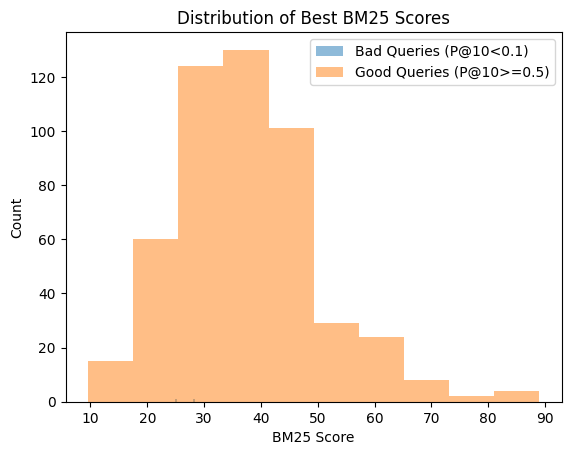

time: 1min 56s (started: 2025-03-25 16:53:35 +01:00)


In [46]:
def best_bm25_score(qid):
    query_str = queries.loc[queries.qid == qid, 'query'].values[0]
    query_tokens = vectorizer.build_analyzer()(query_str)
    scores = bm25.get_scores(query_tokens)
    return scores.max()

best_scores = training_queries['qid'].progress_apply(best_bm25_score)

p10_scores = bm25results.reset_index(drop=True)
best_scores = best_scores.reset_index(drop=True)

# we define "bad" queries as those with P@10 < 0.3
bad_mask = (p10_scores < 0.3)
good_mask = (p10_scores >= 0.5)

bad_best_scores = best_scores[bad_mask]
good_best_scores = best_scores[good_mask]

plt.hist(bad_best_scores, alpha=0.5, label='Bad Queries (P@10<0.1)')
plt.hist(good_best_scores, alpha=0.5, label='Good Queries (P@10>=0.5)')
plt.title("Distribution of Best BM25 Scores")
plt.xlabel("BM25 Score")
plt.ylabel("Count")
plt.legend()
plt.show()


# 🚀 spacy

- look at https://github.com/explosion/sense2vec/blob/master/README.md

In [48]:
nlp = spacy.load('en_core_web_lg') # or the smaller md model!!!

time: 2.06 s (started: 2025-03-25 17:04:33 +01:00)


### 🚧 todo:
- explain what's going on here:

In [49]:
sent1 = nlp("I am happy")
sent2 = nlp("I am sad")
sent3 = nlp("I am joyful")
sent1.similarity(sent2), sent1.similarity(sent3)

(0.9492464661598206, 0.9303178191184998)

time: 42.8 ms (started: 2025-03-25 17:04:38 +01:00)


spacy’s similarity score measures how closely the sentences (and underlying words) appear together in real text corpora. It does not measure purely conceptual or emotional sameness, which is why “happy” and “sad” can appear unexpectedly similar.

### let's try sense2vec

- depending on your machine, download one of the two versions of sense2vec from https://github.com/explosion/sense2vec/blob/master/README.md
  - s2v_reddit_2019_lg 	4 GB 	Reddit comments 2019 (01-07) 	part 1, part 2, part 3
      - cat s2v_reddit_2019_lg.tar.gz.* > s2v_reddit_2019_lg.tar.gz
  - s2v_reddit_2015_md 	573 MB 	Reddit comments 2015 	part 1
- unzip
- try it, and understand what's going on:


In [50]:
s2v = Sense2Vec().from_disk("./s2v_old")

time: 6.04 s (started: 2025-03-25 17:09:11 +01:00)


In [51]:
seeds = "natural language processing, machine learning, artificial intelligence".split(',')
seed_keys = [s2v.get_best_sense(seed.strip()) for seed in seeds]
seed_keys

['natural_language_processing|NOUN',
 'machine_learning|NOUN',
 'artificial_intelligence|NOUN']

time: 7.03 ms (started: 2025-03-25 17:09:21 +01:00)


In [52]:
most_similar = s2v.most_similar(seed_keys, n=10)
most_similar

[('deep_learning|NOUN', np.float32(0.909)),
 ('computer_vision|NOUN', np.float32(0.9051)),
 ('neural_nets|NOUN', np.float32(0.8968)),
 ('neural_networks|NOUN', np.float32(0.8784)),
 ('Machine_learning|NOUN', np.float32(0.8629)),
 ('genetic_algorithms|NOUN', np.float32(0.8488)),
 ('data_analysis|NOUN', np.float32(0.8483)),
 ('big_data|NOUN', np.float32(0.8476)),
 ('complexity_theory|NOUN', np.float32(0.8428)),
 ('data_science|NOUN', np.float32(0.8413))]

time: 2.23 s (started: 2025-03-25 17:09:23 +01:00)


### 🚧 todo: what is it that you couldn't do in Word2Vec?
- just one line of answer.
- answer: We couldn't disambiguate words by their different senses in Word2Vec

- most_similar is very slow. check this to speed things up (optional): https://towardsdatascience.com/how-to-build-a-fast-most-similar-words-method-in-spacy-32ed104fe498
### 🚧 todo:
- try also the following functions: 
    - similarity, get_other_senses, get_freq, s2v[query]


In [54]:
sim_score = s2v.similarity("machine_learning|NOUN", "artificial_intelligence|NOUN")
print("Similarity between 'machine_learning|NOUN' and 'artificial_intelligence|NOUN':", sim_score)

machine_key = s2v.get_best_sense("machine")
print("Best sense for 'machine':", machine_key)

other_senses_for_machine = s2v.get_other_senses(machine_key)
print("Other senses for 'machine':", other_senses_for_machine)

freq = s2v.get_freq("machine_learning|NOUN")
print("Frequency of 'machine_learning|NOUN':", freq)

vec = s2v["machine_learning|NOUN"]
print("Shape of vector for 'machine_learning|NOUN':", vec.shape)

Similarity between 'machine_learning|NOUN' and 'artificial_intelligence|NOUN': 0.77530706
Best sense for 'machine': machine|NOUN
Other senses for 'machine': ['machine|VERB', 'Machine|LOC', 'Machine|ORG', 'Machine|PERSON', 'Machine|GPE']
Frequency of 'machine_learning|NOUN': 1825
Shape of vector for 'machine_learning|NOUN': (128,)
time: 5.85 ms (started: 2025-03-25 17:24:10 +01:00)


### 🚧 todo:
- try whether expanding your query by adding similar terms to the 10 worst queries improves the results


In [55]:
def expand_query_with_sense2vec(query, n_expansions=1, similarity_threshold=0.8):
    tokens = query.lower().split()
    expanded_tokens = []

    for token in tokens:
        best_sense = s2v.get_best_sense(token)
        if not best_sense:
            expanded_tokens.append(token)
            continue

        expanded_tokens.append(token)

        similar_senses = s2v.most_similar(best_sense, n=5)

        filtered_senses = [
            (sense_key, score)
            for (sense_key, score) in similar_senses
            if score >= similarity_threshold
        ]

        expansions = []
        for i, (sense_key, score) in enumerate(filtered_senses):
            if i < n_expansions:
                term = sense_key.split("|")[0]
                term = term.replace("_", " ")
                expansions.append(term)

        expanded_tokens.extend(expansions)
    
    expanded_query = " ".join(expanded_tokens)
    return expanded_query

expanded_queries = []
for idx, row in worst10_queries.iterrows():
    original_q = row["query"]
    expanded_q = expand_query_with_sense2vec(original_q, n_expansions=1, similarity_threshold=0.8)
    expanded_queries.append(expanded_q)

worst10_queries["expanded_query"] = expanded_queries

worst10_queries[["qid", "query", "expanded_query", "bm25_p@10"]]

,qid,query,expanded_query,bm25_p@10
172,729561,what is channeling,what just what is 's channeling channelling,0.1
398,195543,goes how long cost and valid,goes comes how what long cost costs and with v...,0.2
37,417380,is mark applier?,is 's mark chosen applier?,0.4
308,651254,what does the name connor mean,what just what does does't the in name actual ...,0.5
285,127145,define skin doctor,define defining skin normal skin doctor regula...,0.6
167,859358,what is uplifting in geography,what just what is 's uplifting upbeat in the g...,0.6
443,11059,actresses who died of lung cancer,actresses actors/actresses who only people die...,0.6
456,868366,what kind of food should heart attached person,what just what kind sort of the food fresh foo...,0.7
184,1078582,wired definition,wired hardwired definition defintion,0.7
455,567103,what are the airports in south virginia,what just what are those the in airports train...,0.7


time: 1min 36s (started: 2025-03-25 17:27:20 +01:00)


### 🚧 todo:
- try misspelling a word and see whether you can fix that with sense2vec


In [57]:
import difflib

def get_all_words(s2v):
    sense_keys = list(s2v.keys())
    
    words = []
    for key in sense_keys:
        if "|" in key:
            word, pos = key.rsplit("|", 1)
            words.append(word.replace("_", " "))
    
    return list(set(words))

all_words = get_all_words(s2v)

misspelled = "machien"

candidates = difflib.get_close_matches(misspelled, all_words, n=1, cutoff=0.6)
if not candidates:
    print(f"No good match found for '{misspelled}'")
else:
    corrected = candidates[0]
    print(f"Misspelled word: '{misspelled}'  -->  Best match: '{corrected}'")
    best_sense_key = s2v.get_best_sense(corrected)
    print("Best sense key:", best_sense_key)

    most_similar = s2v.most_similar(best_sense_key, n=5)
    print("Top 5 similar sense-keys:\n", most_similar)


Misspelled word: 'machien'  -->  Best match: 'machin'
Best sense key: machin|NOUN
Top 5 similar sense-keys:
 [('virer|NOUN', np.float32(0.8474)), ('sinon|NOUN', np.float32(0.8458)), ("j'me|NOUN", np.float32(0.8424)), ("quelqu'un|NOUN", np.float32(0.8414)), ('expliqué|NOUN', np.float32(0.841))]
time: 4.68 s (started: 2025-03-25 17:36:12 +01:00)


### 🚧 todo:
- try embeddings for a few queries (all would take to long except if you have a GPU)
    - are the gold top 10 similar to the query itself?
    - check whether the gold top 10 answers for our most difficult question are really closer to the question than the currently predicted top10
         - how to get every doc as a vector: 
             - https://spacy.io/api/doc#vector "A real-valued meaning representation. Defaults to an average of the token vectors."
        - every doc has a similarity function taking another doc as argument: 
            - https://spacy.io/api/doc#similarity

In [59]:
queries = [
    "what is channeling",
    "what is uplifting in geography"
]

gold_doc_texts = {
    "what is channeling": [
        "Channeling is a form of communication with spirits ...",
    ],
    "what is uplifting in geography": [
        "Geologic uplift involves the upward movement of Earth's surface ...",
    ]
}

predicted_doc_texts = {
    "what is channeling": [
        "A television channel is a frequency band ...",
    ],
    "what is uplifting in geography": [
        "To uplift spirits means to elevate mood ...",
    ]
}

for query in queries:
    query_doc = nlp(query)
    print(f"\nQuery: {query}")
    
    gold_scores = []
    for doc_text in gold_doc_texts[query]:
        doc_doc = nlp(doc_text)
        sim = query_doc.similarity(doc_doc)
        gold_scores.append(sim)
    avg_gold_sim = sum(gold_scores) / len(gold_scores)
    
    pred_scores = []
    for doc_text in predicted_doc_texts[query]:
        doc_doc = nlp(doc_text)
        sim = query_doc.similarity(doc_doc)
        pred_scores.append(sim)
    avg_pred_sim = sum(pred_scores) / len(pred_scores)
    
    print("Gold similarities:", gold_scores)
    print("Predicted similarities:", pred_scores)
    print(f"Avg gold similarity: {avg_gold_sim:.4f}")
    print(f"Avg predicted similarity: {avg_pred_sim:.4f}")


Query: what is channeling
Gold similarities: [0.7957676649093628]
Predicted similarities: [0.6488352417945862]
Avg gold similarity: 0.7958
Avg predicted similarity: 0.6488

Query: what is uplifting in geography
Gold similarities: [0.7252493500709534]
Predicted similarities: [0.6907057762145996]
Avg gold similarity: 0.7252
Avg predicted similarity: 0.6907
time: 149 ms (started: 2025-03-25 17:39:44 +01:00)


In [ ]:
# not necessary but if you want to include your big s2v file
# combining spacy and sense2vec:
nlp = spacy.load("en_core_web_sm") # or whichever you downloaded
s2v = nlp.add_pipe("sense2vec")
s2v.from_disk("./s2v_reddit_2015_md") # or whichever you downloaded